# **TAREA MÓDULO 8 - MÉTODOS AVANZADOS EN MACHINE LEARNING** #

La empresa ROMA es un retailer chileno que vende productos de consumo masivo, y necesita determinar qué productos deben seguir vendiendo y qué productos deben remover de su stock, con el objetivo de reducir costos de inventario. Los costos asociados a inventario se entienden como la suma del costo de mantener un producto que no se venderá y el costo de oportunidad de tener quiebres en stock en productos que tienen una alta rotación. La empresa tiene información histórica que podría utilizar para identificar qué productos deben mantenerse y cuáles pueden ser removidos.  
  
Roma entrega un archivo consolidado que contiene datos históricos: Niveles inventarios, SKU, precios promedios, mínimo, y otra información relevante, además incluye una variable que indica si los productos tuvieron una venta lo suficientemente alta para cubrir los costos de inventarios, durante los últimos 6 meses.  
  
### **OBJETIVO** ###  
Construir el mejor modelo predictivo que indique que producto tendrá nivel de venta esperado alto. Esto puede realizarse mediante un modelo de clasificación binaria:

* 1: Alto nivel de venta esperado -> No debe removerse del stock
* 0: Bajo nivel de venta esperado -> Debe removerse del stock
  
El threshold del modelo que construya debe considerar que el costo de clasificar mal un producto con bajo nivel de ventas esperadas (predecir 1 cuando era 0) corresponde a **10 UM**, mientras que el costo de clasificar mal a un producto con alto nivel de ventas (predecir 0 cuando era 1) es **15 UM**.

## **ANÁLISIS EXPLORATORIO DE DATOS (EDA)** ##  
Se inicia el trabajo con el EDA para conocer la base e identificar valores anómalos que deban ser aborados.

In [65]:
#Importación de librerías

from google.colab import files
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
#Lectura del archivo

df = pd.read_csv("/content/drive/MyDrive/TRAIN.txt", delimiter="\t")
df.head()

,ORDEN,SKU,VENTA_ALTA,MARKETING,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
0,50833,2253302,0,S,2,1,192034,58.16,2006,40,34.52,46.58
1,67770,700754,0,S,2,1,3891897,30.95,2004,20,30.99,16.98
2,71253,528795,0,S,2,1,245070,49.99,2010,32,14.01,30.98
3,31295,901250,0,D,4,1,3480889,390.00,2004,21,0.00,73.13
4,43339,578450,0,S,5,1,1422247,51.95,1990,35,4.99,35.99


In [23]:
#Forma del dataframe

df.shape

(50000, 12)

La base consta de 50.000 registros con 12 columnas.

In [24]:
#Tipos de varibales en las columnas

df.dtypes

ORDEN                  int64
SKU                    int64
VENTA_ALTA             int64
MARKETING             object
ACTUALIZACIONES        int64
ACTUALIZADO            int64
VENTAS_ACUMULADAS      int64
PRICE                float64
LANZAMIENTO            int64
CANTIDAD               int64
PRECIO_MIN           float64
SD_PRECIO            float64
dtype: object

De las 12 columnas, sólo 1 es una variable de texto (String). Las otras 11 son  numéricas, siendo 8 de tipo enteros (Integer) y 3 de tipo punto flotante (Float).

In [25]:
#Revisión de registros con ventas altas

df[df["VENTA_ALTA"]==1]

,ORDEN,SKU,VENTA_ALTA,MARKETING,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
5,28719,494719,1,D,2,1,67044,61.63,2009,46,65.08,75.70
6,28966,174581,1,D,1,0,773423,106.00,2000,23,72.02,94.66
14,15402,608676,1,D,10,1,1065643,162.95,2000,21,690.59,101.45
16,6731,196765,1,D,6,1,2922217,178.00,2005,19,102.87,69.21
23,83144,624641,1,S,3,1,125,29.25,2014,356,44.99,10.49
...,...,...,...,...,...,...,...,...,...,...,...,...
49982,14479,196581,1,D,1,0,1637549,69.95,2006,20,28.34,45.11
49985,30426,536915,1,D,8,1,4829,227.60,2012,146,162.98,60.92
49986,69393,101553,1,S,1,0,243864,125.45,2001,79,0.00,45.43
49993,26395,54436,1,D,10,1,488485,194.95,2007,76,114.19,20.24


8.479 registros tienen ventas altas.

In [26]:
#Información de los valores en las columnas

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ORDEN              50000 non-null  int64  
 1   SKU                50000 non-null  int64  
 2   VENTA_ALTA         50000 non-null  int64  
 3   MARKETING          50000 non-null  object 
 4   ACTUALIZACIONES    50000 non-null  int64  
 5   ACTUALIZADO        50000 non-null  int64  
 6   VENTAS_ACUMULADAS  50000 non-null  int64  
 7   PRICE              50000 non-null  float64
 8   LANZAMIENTO        50000 non-null  int64  
 9   CANTIDAD           50000 non-null  int64  
 10  PRECIO_MIN         50000 non-null  float64
 11  SD_PRECIO          50000 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 4.6+ MB


De los 50.000 registros, ninguna variable tiene valores nulos.

In [27]:
#Estadística descriptiva de las variables numéricas

df.describe()

,ORDEN,SKU,VENTA_ALTA,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
count,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,41608.197720,6.547387e+05,0.169580,4.131420,0.788620,1.224657e+06,98.865903,2005.977820,43.839840,56.677897,47.179870
std,25060.031804,6.894816e+05,0.375267,3.883587,0.408291,1.545868e+06,79.382973,6.094617,36.166622,94.566111,134.956989
min,3.000000,5.000100e+04,0.000000,0.000000,0.000000,1.250000e+02,0.000000,1935.000000,0.000000,0.000000,0.000000
25%,19431.500000,1.701395e+05,0.000000,2.000000,1.000000,2.444565e+05,49.950000,2003.000000,22.000000,20.627500,18.630000
50%,41409.500000,5.414555e+05,0.000000,3.000000,1.000000,7.154770e+05,78.670000,2007.000000,34.000000,43.990000,35.990000
75%,63569.250000,7.612125e+05,0.000000,6.000000,1.000000,1.561518e+06,127.800000,2010.000000,53.000000,79.332500,56.812500
max,85105.000000,3.959831e+06,1.000000,97.000000,1.000000,1.666966e+07,3986.310000,2017.000000,930.000000,10003.970000,19138.790000


No se identifican variables con valores que deban ser depurados.

In [42]:
#Detalle de los valores de las variables numéricas y de texto

y_var = "VENTA_ALTA"
x_var = ["MARKETING","ACTUALIZACIONES", "ACTUALIZADO", "VENTAS_ACUMULADAS", "PRICE", "LANZAMIENTO", "CANTIDAD", "PRECIO_MIN", "SD_PRECIO"]

lista = list()

for variable in x_var:
  d = dict()
  d["var"] = variable
  d["unic_val"] = len(df[variable].unique())
  d["tipo"] = df[variable].dtype
  d["nulos"] = len(df[df[variable].isna()])
  if d["tipo"] != "object":
    d["media"] = df[variable].mean()
    d["min"] = df[variable].min()
    d["max"] = df[variable].max()
    d["zeros"] = len(df[df[variable]==0])/len(df)
  d["valores"] = ",".join([str(x) for x in random.choices(df[variable].unique().tolist(), k=4)])
  lista.append(d)

resumen_variables = pd.DataFrame(lista)
resumen_variables

,var,unic_val,tipo,nulos,valores,media,min,max,zeros
0,MARKETING,2,object,0,"S,S,D,S",NaN,NaN,NaN,NaN
1,ACTUALIZACIONES,58,int64,0,"5,32,25,57",4.131420e+00,0.0,97.00,0.08616
2,ACTUALIZADO,2,int64,0,"1,0,1,1",7.886200e-01,0.0,1.00,0.21138
3,VENTAS_ACUMULADAS,49382,int64,0,"674390,472610,45988,55287",1.224657e+06,125.0,16669658.00,0.00000
4,PRICE,7239,float64,0,"60.9,109.15,6.2,91.45",9.886590e+01,0.0,3986.31,0.01826
5,LANZAMIENTO,65,int64,0,"1982,1952,2015,2000",2.005978e+03,1935.0,2017.00,0.00000
6,CANTIDAD,358,int64,0,"120,128,290,281",4.383984e+01,0.0,930.00,0.00120
7,PRECIO_MIN,10224,float64,0,"11.97,4.72,50.05,56.26",5.667790e+01,0.0,10003.97,0.11900
8,SD_PRECIO,10977,float64,0,"59.05,87.62,66.29,60.84",4.717987e+01,0.0,19138.79,0.02874


La variable "MARKETING" es la única que no es numérica y posee sólo 2 valores, que pueden ser "S" o "D".  
La variables "ACTUALIZADO" es una variable binaria tomando valores 0 y 1.

In [30]:
#Creación de variables dummies para "MARKETING"

df["MARKETING_DUMMY"] = pd.get_dummies(df["MARKETING"],drop_first=True)
x_var = ["MARKETING_DUMMY","ACTUALIZACIONES", "ACTUALIZADO", "VENTAS_ACUMULADAS", "PRICE", "LANZAMIENTO", "CANTIDAD", "PRECIO_MIN", "SD_PRECIO"]
df[x_var].head()

,MARKETING_DUMMY,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
0,1,2,1,192034,58.16,2006,40,34.52,46.58
1,1,2,1,3891897,30.95,2004,20,30.99,16.98
2,1,2,1,245070,49.99,2010,32,14.01,30.98
3,0,4,1,3480889,390.00,2004,21,0.00,73.13
4,1,5,1,1422247,51.95,1990,35,4.99,35.99


Se crea la variable "MARKETING_DUMMY" para pasar de una variable categórica a una binaria.

## **ENTRENAMIENTO DEL MODELO - RANDOM FOREST** ##  

In [31]:
#Carga de librería y separación de la base

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[x_var], df[y_var], test_size = 0.2, random_state = 0)

In [109]:
#Importación de librerías

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_roc_curve

In [44]:
#Definición del modelo y entrenamiento

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)
y_pred_noprob = rf.predict(X_test)

In [34]:
#Puntaje del modelo

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.754677183353122

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Cruva ROC')

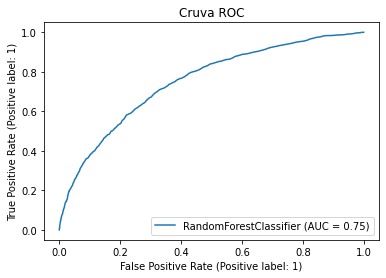

In [112]:
#Ploteo de la curva ROC

plot_roc_curve(rf, X_test, y_test)
plt.title("Cruva ROC")

In [57]:
#Matriz de confusión para los valores predichos por el modelo (corte 0.5)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_noprob).ravel()
print("TN: " +str(tn)+"\nFP: "+str(fp)+"\nFN: "+str(fn)+"\nTP: "+str(tp))

TN: 8047
FP: 227
FN: 1434
TP: 292


In [58]:
#Cálculo del costo del modelo

model_cost = fp*10 + fn*15
print("El modelo tiene un costo de "+str(model_cost)+" UN")

El modelo tiene un costo de 23780 UN


Usando un random forest con 500 árboles y un punto de corte de 0.5 (usando la clasificación que entrega el modelo) se obtiene un modelo con un costo total de **23.780 UN**.

In [51]:
#Se determina la clasificación (binaria) a partir del puntaje entregado por el modelo usando explícitamente un punto de corte

p_corte = 0.5 #Se usa 0.5 para comprobar los resultados
y_pred_corte =[]

for valor in y_pred[:,1]:
  if valor <= p_corte:
    y_pred_corte.append(0)
  else:
    y_pred_corte.append(1)

In [59]:
#Matriz de confusión para los valores usando el punto de corte de 0.5 (para comprobar con los valores anteriores)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_corte).ravel()
print("TN: " +str(tn)+"\nFP: "+str(fp)+"\nFN: "+str(fn)+"\nTP: "+str(tp))

TN: 8047
FP: 227
FN: 1434
TP: 292


In [60]:
#Iteración de puntos de corte para identificar uno de menor costo

l = []
for i in range(1,100):
  t=i/100
  pred = np.where(y_pred[:,1]>t,1,0)
  FP = np.where((pred==1) & (y_test==0),1,0).sum()
  FN = np.where((pred==0) & (y_test==1),1,0).sum()
  costo = FP*10 + FN*15
  l.append({"Corte":t, "FP":FP, "FN":FN, "Costo":costo})

t_resumen = pd.DataFrame(l)
t_resumen

,Corte,FP,FN,Costo
0,0.01,8108,5,81155
1,0.02,7750,21,77815
2,0.03,7278,29,73215
3,0.04,6817,59,69055
4,0.05,6339,95,64815
...,...,...,...,...
94,0.95,0,1726,25890
95,0.96,0,1726,25890
96,0.97,0,1726,25890
97,0.98,0,1726,25890


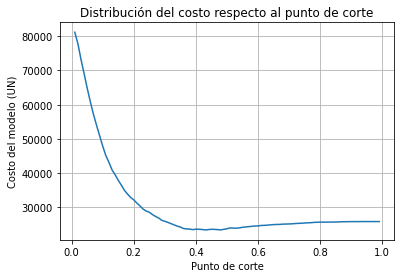

In [69]:
#Mostrar la distribución de los costos respecto al punto de corte

etiquetas = t_resumen["Corte"]
valores = t_resumen["Costo"]

fig, ax = plt.subplots()

graph = ax.plot(etiquetas,valores)

ax.set_xlabel("Punto de corte")
ax.set_ylabel("Costo del modelo (UN)")
plt.grid(b=True)
plt.title("Distribución del costo respecto al punto de corte")
plt.show()

In [63]:
#Identificar el punto de corte con menor costo

t_resumen.sort_values("Costo").head(1)

,Corte,FP,FN,Costo
42,0.43,416,1286,23450


Habiendo entrenado un modelo de random forest con 500 árboles y usando un punto de corte de 0,43 se tiene el menor costo de 23.450 UN.

In [76]:
#Carga del archivo submit

df_submit = pd.read_csv("/content/drive/MyDrive/SUBMIT.txt", delimiter="\t")
df_submit

,SKU,PRED,PRED_CLASS
0,193672,NaN,NaN
1,255098,NaN,NaN
2,533439,NaN,NaN
3,218779,NaN,NaN
4,113098,NaN,NaN
...,...,...,...
10792,555772,NaN,NaN
10793,615886,NaN,NaN
10794,914042,NaN,NaN
10795,1481052,NaN,NaN


In [75]:
#Carga del archivo test

df_test = pd.read_csv("/content/drive/MyDrive/TEST.txt", delimiter="\t")
df_test

,ORDEN,SKU,VENTA_ALTA,MARKETING,ACTUALIZACIONES,ACTUALIZADO,VENTAS_ACUMULADAS,PRICE,LANZAMIENTO,CANTIDAD,PRECIO_MIN,SD_PRECIO
0,18209,193672,NaN,D,3,1,394494,83.95,2009,38,11.44,46.23
1,51444,255098,NaN,S,0,0,675213,75.00,2005,47,43.99,61.97
2,23089,533439,NaN,D,7,1,46093,87.00,2011,42,80.79,82.12
3,15957,218779,NaN,D,2,1,352081,86.95,2001,23,73.14,69.63
4,28213,113098,NaN,D,3,1,228992,165.00,2007,24,141.05,153.63
...,...,...,...,...,...,...,...,...,...,...,...,...
10792,13486,555772,NaN,D,2,1,326268,87.95,2010,89,75.58,7.48
10793,69406,615886,NaN,S,1,0,236722,105.80,2007,84,21.89,83.98
10794,76855,914042,NaN,S,3,1,2892691,66.95,1991,18,88.99,26.56
10795,24057,1481052,NaN,D,1,0,746557,134.27,2011,18,57.19,8.79


In [83]:
#Verificación de que los SKU del submit y test son iguales

pd.DataFrame(df_submit["SKU"]==df_test["SKU"])["SKU"].unique()

array([ True])

In [85]:
#Se usa el modelo para predecir los valores de los productos del archivo test

df_test["MARKETING_DUMMY"] = pd.get_dummies(df_test["MARKETING"],drop_first=True)
x_var = ["MARKETING_DUMMY","ACTUALIZACIONES", "ACTUALIZADO", "VENTAS_ACUMULADAS", "PRICE", "LANZAMIENTO", "CANTIDAD", "PRECIO_MIN", "SD_PRECIO"]

y_test_pred = rf.predict_proba(df_test[x_var])
y_test_pred

array([[0.8  , 0.2  ],
       [0.886, 0.114],
       [0.516, 0.484],
       ...,
       [0.958, 0.042],
       [0.81 , 0.19 ],
       [0.876, 0.124]])

In [104]:
#Guardando los resultados

submit = pd.DataFrame(df_test["SKU"]) #Agrega el SKU a guardar
submit["PRED"] = y_test_pred[:,1] #Agrega la predicción continua

p_corte = 0.43 #Usando punto de corte de menor costo
y_pred_class =[]

for valor in y_test_pred[:,1]:
  if valor <= p_corte:
    y_pred_class.append(0)
  else:
    y_pred_class.append(1)

submit["PRED_CLASS"] = y_pred_class #Agrega predicción usando el punto de corte

submit

,SKU,PRED,PRED_CLASS
0,193672,0.200,0
1,255098,0.114,0
2,533439,0.484,1
3,218779,0.212,0
4,113098,0.306,0
...,...,...,...
10792,555772,0.396,0
10793,615886,0.284,0
10794,914042,0.042,0
10795,1481052,0.190,0


In [108]:
#Guarda el archivo en Google Drive

submit.to_csv('/content/drive/MyDrive/SUBMIT_entrega.txt', sep="\t", index=False)